In [131]:
import collections
import datetime
import os
import sys

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as sk
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

sys.path.append(os.path.abspath('../Data'))
import queries

In [2]:
server = 'VT3'
schema = 'WCS01600'
features = queries.get_profit_ces_by_day(server, schema)
features.describe().transpose()

count           mean           std         min           25%  \
TYEAR   1301.0    2018.002306      1.407396   2016.0000    2017.00000   
TMON    1301.0       6.524981      3.438295      1.0000       4.00000   
TDAY    1301.0      15.803997      8.749638      1.0000       8.00000   
PROFIT  1301.0  217445.215267  80501.962091 -15223.8972  172435.45100   
CES     1301.0   40186.792017  13836.972197      0.0000   32107.93408   

                50%          75%           max  
TYEAR     2018.0000    2019.0000    2021.00000  
TMON         7.0000      10.0000      12.00000  
TDAY        16.0000      23.0000      31.00000  
PROFIT  218741.1402  268153.7251  549121.79570  
CES      40187.4433   48507.3418   96539.68725

In [3]:
Models = collections.namedtuple('Models', ['MODEL', 'PARAMS'])
Model_Params = collections.namedtuple('Model_Params', ['LOSS', 'OPTIMIZER', 
                                      'EPOCHS', 'CALLBACKS', 'VERBOSE'])

In [319]:
class schema_ML():
    def __init__(self, schema, df):
        
        # Store initial data.
        self.schema = schema
        self.df_initial = df
        
        self.models = {}
        self.model_params = Model_Params('mae', 'adam', 500, [], 2)
        
        self.train_performance = {}
        self.val_performance = {}
        self.mfe = {}
        self.mae = {}
        self.mse = {}
        self.rmse = {}
        
        
        # Preprocess data.
        self.preprocess()
        
    def preprocess(self):
        
        # Reference DF
        df = self.df_initial
        
        # Combine individual date columns to single index
        df = df.rename(columns={'TYEAR':'YEAR', 'TMON':'MONTH', 'TDAY':'DAY'})
        df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])
        df = df.drop(columns=['YEAR', 'MONTH', 'DAY'])
        df.set_index('DATE', inplace=True)
        
        self.df = df
        df.plot(subplots=True, title='Initial Data')
        
        # Add differencing
        df = self.add_differencing(df)
        self.differenced_df = df
        df.plot(subplots=True, title='Added Differencing')
        
        # Normalize using scaler
        scaler = MinMaxScaler(feature_range=(-1,1))
        scaled = scaler.fit_transform(df.values)
        df = pd.DataFrame(scaled, columns=df.columns)
        self.normalized_df = df
        df.plot(subplots=True, title='Added Normalization')
        
        # Split into train/val/test
        n = len(df)
        train_df = df[0:int(n*0.7)]
        val_df = df[int(n*0.7):int(n*0.9)]
        test_df = df[int(n*0.9):]
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.scaler = scaler
        
    def add_differencing(self, df):
        df = df.diff(365)
        
        return df.dropna()
        
    def train_test_split(self, df):
        n = len(df)
        pct_test = (np.log2(n) * 0.01)
        num_test = int(n * pct_test)
        num_train = n - num_test
        
        train = df[:num_train]
        test = df[num_train:]
        
        return train, test
    
    def add_lag(self, df):
        lags = range(1, 2, 1)
        cols = df.columns
        
        lagged = df.assign(**{
            '{} (t-{})'.format(col, t): df[col].shift(t)
            for t in lags
            for col in cols
        })
        
        return lagged.dropna()
    
    def reshape(self, X):
        X = X.values.reshape((X.shape[0], 1, X.shape[1]))
        
        return X
    
    def get_train_and_val(self):
        train = self.train_df
        val = self.val_df

        train = self.add_lag(train)
        val = self.add_lag(val)

        X_train = train.filter(regex='^(?!PROFIT$)')
        Y_train = train.filter(regex='^(PROFIT$)')
        X_val = val.filter(regex='^(?!PROFIT$)')
        Y_val = val.filter(regex='^(PROFIT$)')
    
        X_train, X_val = self.reshape(X_train), self.reshape(X_val)
        
        return X_train, Y_train, X_val, Y_val
    
    def get_test(self):
        test = self.testing
        
        test = self.add_lag(test)
        
        X_test = test.filter(regex='^(?!PROFIT$)')
        Y_test = test.filter(regex='^(PROFIT$)')
        
        X_test = self.reshape(X_test)
        
        return X_test, Y_test
        
    def evaluate_and_plot(self, plot_cols=['PROFIT'], model_name='', model=None, model_params=None):
        
        if model is not None:
        
            # Add model to dictionary
            if model_params == None:
                model_params = self.model_params

            if model is not None:
                self.models[model_name] = Models(model, model_params)

            # Get training and validation data
            X_train, Y_train, X_val, Y_val = self.get_train_and_val()

            # Compile model    
            model.compile(loss=model_params.LOSS, optimizer=model_params.OPTIMIZER)
            
            # Fit model to training data
            history = model.fit(X_train, Y_train, epochs=model_params.EPOCHS, 
                                callbacks=model_params.CALLBACKS, validation_data=(X_val, Y_val),
                                verbose=model_params.VERBOSE, shuffle=False)

            # Add validation information to dictionary
            self.train_performance[model_name] = min(history.history['loss'])
            self.val_performance[model_name] = min(history.history['val_loss'])
            
            # Plot train vs. val losses
            plt.plot(history.history['loss'], label='train')
            plt.plot(history.history['val_loss'], label='val')
            plt.title('Training Loss vs. Validation Loss')
            plt.xlabel('# of Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()
            
            # Calculate performance metrics and add to dictionaries
            expected = Y_val.values
            predicted = model(X_val)
            forecast_errors = [expected[i] - predicted[i] for i in range(len(expected))]
            
            mfe = np.mean(forecast_errors)
            mae = mean_absolute_error(expected, predicted)
            mse = mean_squared_error(expected, predicted)
            rmse = np.sqrt(mse)
            
            self.mfe[model_name] = mfe
            self.mae[model_name] = mae
            self.mse[model_name] = mse
            self.rmse[model_name] = rmse
            
            # Plot expected vs predicted
            plt.figure(figsize=(40,8))
            plt.plot(self.val_df.index[1:], expected, label='Expected', marker='.', zorder=-10)
            plt.scatter(self.val_df.index[1:], predicted, label='Predicted', edgecolors='k', c='#2ca02c', s=64)
            plt.show()
            
            ### TEST - Inverse transform scaler ###
            
            scaler = self.scaler
            df_one = self.train_df
            df_three = self.test_df
            expected_df = pd.DataFrame(expected, index=Y_val.index, columns=Y_val.columns)
            predicted_df = pd.DataFrame(predicted.numpy(), index=Y_val.index, columns=Y_val.columns)
            
            expected_frames = [df_one[['PROFIT', 'CES']], expected_df, df_three[['PROFIT', 'CES']]]
            predicted_frames = [df_one[['PROFIT', 'CES']], predicted_df, df_three[['PROFIT', 'CES']]]
            full_expected_df = pd.concat(expected_frames)
            full_predicted_df = pd.concat(predicted_frames)
            
            inverse_expected = scaler.inverse_transform(full_expected_df)
            inverse_predicted = scaler.inverse_transform(full_predicted_df)
            
            indexes = df_one.index.union(expected_df.index).union(df_three.index)      
            inverse_expected_df = pd.DataFrame(inverse_expected, index=indexes)
            print(inverse_expected_df)
            
            
#             inverse_expected_df = pd.DataFrame(inverse_expected, index=self.df_initial.index, columns=['PROFIT', 'CES'])
#             inverse_predicted_df = pd.DataFrame(inverse_predicted, index=self.df_initial.index, columns=['PROFIT', 'CES'])
            
            ### END TEST ###
            
            
        # Plot specified columns and results
        
        
    def performance_metrics(self):
        
        # Convert dictionarites to single dataframe
        mfe_df = pd.DataFrame.from_dict(self.mfe, columns=['MFE'], orient='index')
        mae_df = pd.DataFrame.from_dict(self.mae, columns=['MAE'], orient='index')
        mse_df = pd.DataFrame.from_dict(self.mse, columns=['MSE'], orient='index')
        rmse_df = pd.DataFrame.from_dict(self.rmse, columns=['RMSE'], orient='index')
        performance_df = mfe_df.join(mae_df).join(mse_df).join(rmse_df)
        performance_df = performance_df.transpose()
        
        performance_df.plot(kind='bar')
        plt.show()
        print(performance_df)

        

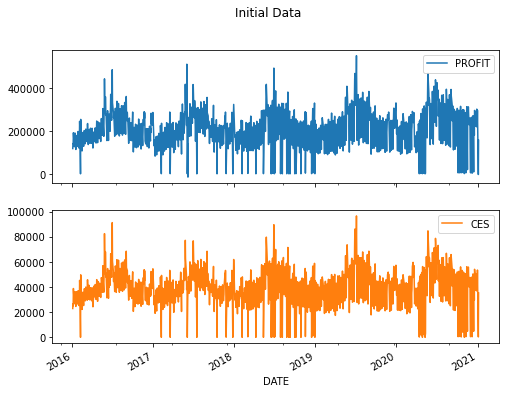

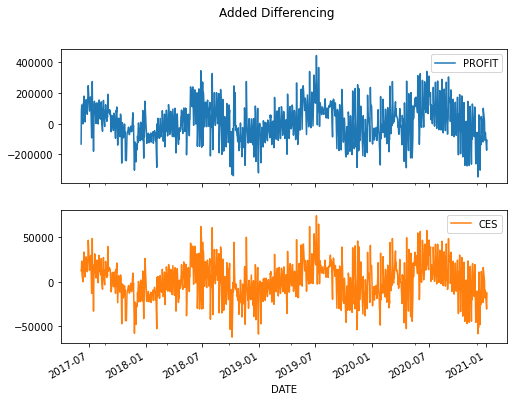

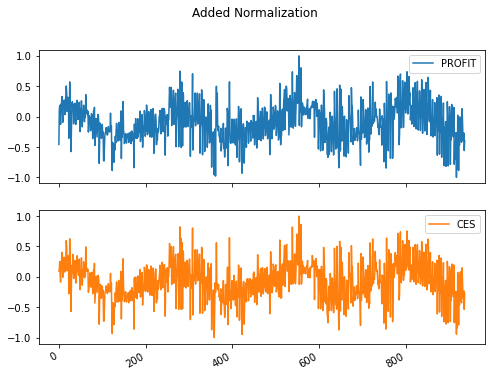

In [320]:
obj = schema_ML(schema, features)

Epoch 1/500
21/21 - 3s - loss: 0.2382 - val_loss: 0.2280
Epoch 2/500
21/21 - 0s - loss: 0.2110 - val_loss: 0.2098
Epoch 3/500
21/21 - 0s - loss: 0.1856 - val_loss: 0.1907
Epoch 4/500
21/21 - 0s - loss: 0.1618 - val_loss: 0.1701
Epoch 5/500
21/21 - 0s - loss: 0.1420 - val_loss: 0.1498
Epoch 6/500
21/21 - 0s - loss: 0.1239 - val_loss: 0.1295
Epoch 7/500
21/21 - 0s - loss: 0.1050 - val_loss: 0.1071
Epoch 8/500
21/21 - 0s - loss: 0.0841 - val_loss: 0.0815
Epoch 9/500
21/21 - 0s - loss: 0.0616 - val_loss: 0.0544
Epoch 10/500
21/21 - 0s - loss: 0.0419 - val_loss: 0.0401
Epoch 11/500
21/21 - 0s - loss: 0.0372 - val_loss: 0.0385
Epoch 12/500
21/21 - 0s - loss: 0.0370 - val_loss: 0.0381
Epoch 13/500
21/21 - 0s - loss: 0.0367 - val_loss: 0.0376
Epoch 14/500
21/21 - 0s - loss: 0.0363 - val_loss: 0.0373
Epoch 15/500
21/21 - 0s - loss: 0.0361 - val_loss: 0.0370
Epoch 16/500
21/21 - 0s - loss: 0.0359 - val_loss: 0.0368
Epoch 17/500
21/21 - 0s - loss: 0.0360 - val_loss: 0.0368
Epoch 18/500
21/21 - 0s

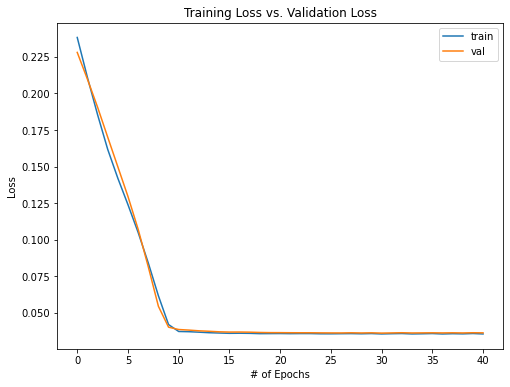

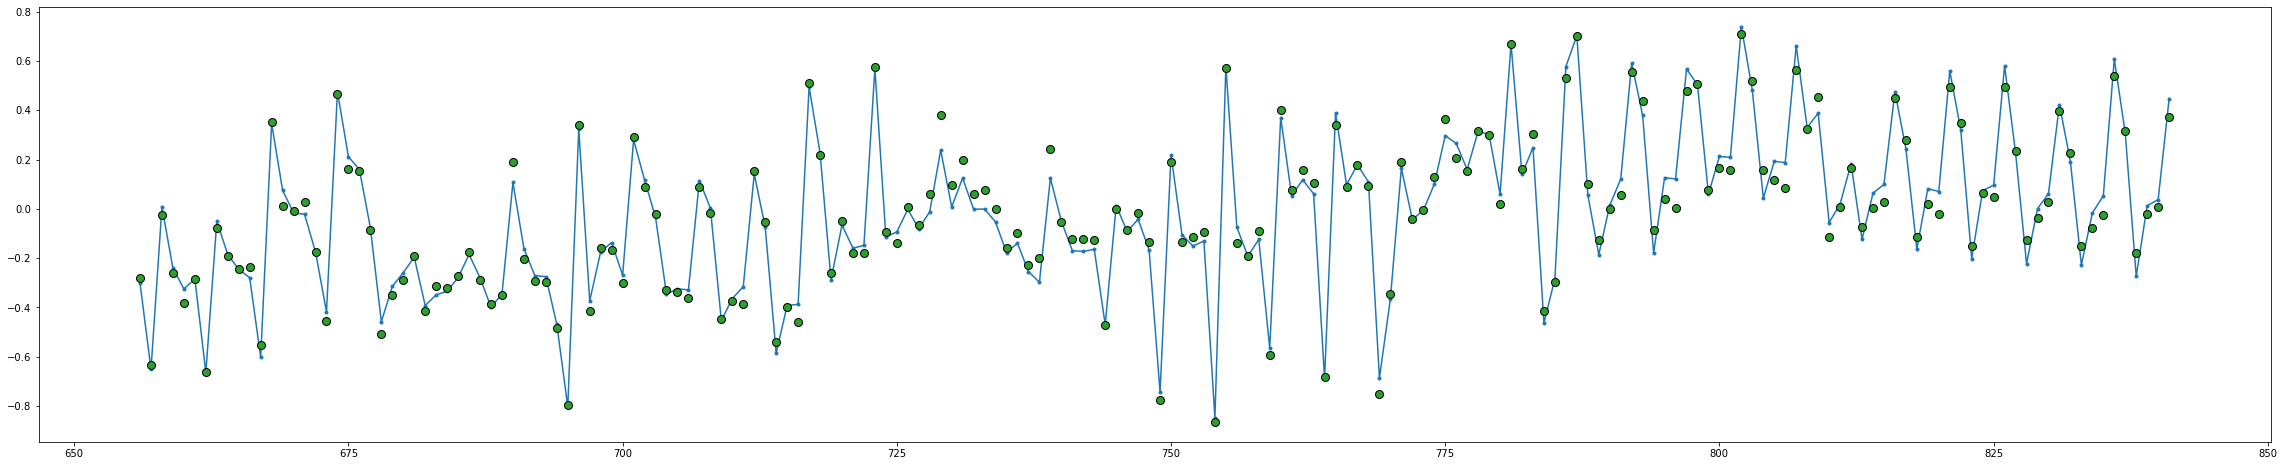

tf.Tensor(
[[ 0.1485774 ]
 [ 0.31214204]
 [ 0.14857276]
 [ 0.31214204]
 [ 0.13892435]
 [ 0.31214204]
 [ 0.31214204]
 [ 0.13892435]
 [-0.06986248]
 [ 0.31214204]
 [ 0.31214204]
 [ 0.14857276]
 [ 0.13892435]
 [ 1.6865    ]
 [ 0.14857276]
 [ 0.31214204]
 [ 0.14857276]
 [ 0.13892435]
 [ 2.324553  ]
 [ 0.31214204]
 [ 0.31214204]
 [ 0.14857276]
 [ 0.13892435]
 [ 0.95411235]
 [ 0.31214204]
 [ 0.14857276]
 [ 0.14857276]
 [ 0.13892435]
 [ 0.95411235]
 [ 0.31214204]
 [ 0.31214204]
 [ 0.14857276]
 [ 0.13892435]
 [ 1.6865    ]
 [ 0.31214204]
 [ 0.14857276]
 [ 0.14857276]
 [ 0.13892435]
 [ 2.324553  ]
 [ 0.14857276]
 [ 0.17723969]
 [ 0.14857276]
 [ 0.13892435]
 [ 1.358297  ]
 [ 0.31214204]
 [ 0.31214204]
 [ 0.14857276]
 [ 0.14857276]
 [ 0.09487818]
 [ 0.31214204]
 [ 0.31214204]
 [ 0.13892435]
 [ 2.324553  ]
 [ 0.14857276]
 [ 0.31214204]
 [ 0.14857276]
 [ 0.13892435]
 [ 2.324553  ]
 [ 0.14857276]
 [ 0.31214204]
 [ 0.14857276]
 [ 0.13892435]
 [ 0.95411235]
 [ 0.31214204]
 [ 0.31214204]
 [ 0.14857276]

In [321]:
MONITOR = 'val_loss'
PATIENCE = 10
RESTORE_BEST_WEIGHTS = True
ES = tf.keras.callbacks.EarlyStopping(monitor=MONITOR, patience=PATIENCE, 
                                    restore_best_weights=RESTORE_BEST_WEIGHTS)

LOSS = 'mae'
OPTIMIZER = 'adam'
EPOCHS = 500
CALLBACKS = [ES]
VERBOSE = 2

model_params = Model_Params(LOSS, OPTIMIZER, EPOCHS, CALLBACKS, VERBOSE)
model_name = 'Base LSTM'
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dense(1)
])

obj.evaluate_and_plot(model_name=model_name, model=model, model_params=model_params)


Epoch 1/500
21/21 - 5s - loss: 0.2308 - val_loss: 0.2138
Epoch 2/500
21/21 - 0s - loss: 0.1693 - val_loss: 0.1565
Epoch 3/500
21/21 - 0s - loss: 0.1132 - val_loss: 0.1011
Epoch 4/500
21/21 - 0s - loss: 0.0597 - val_loss: 0.0419
Epoch 5/500
21/21 - 0s - loss: 0.0452 - val_loss: 0.0411
Epoch 6/500
21/21 - 0s - loss: 0.0439 - val_loss: 0.0397
Epoch 7/500
21/21 - 0s - loss: 0.0402 - val_loss: 0.0382
Epoch 8/500
21/21 - 0s - loss: 0.0406 - val_loss: 0.0374
Epoch 9/500
21/21 - 0s - loss: 0.0393 - val_loss: 0.0376
Epoch 10/500
21/21 - 0s - loss: 0.0392 - val_loss: 0.0377
Epoch 11/500
21/21 - 0s - loss: 0.0396 - val_loss: 0.0374
Epoch 12/500
21/21 - 0s - loss: 0.0388 - val_loss: 0.0371
Epoch 13/500
21/21 - 0s - loss: 0.0385 - val_loss: 0.0372
Epoch 14/500
21/21 - 0s - loss: 0.0389 - val_loss: 0.0370
Epoch 15/500
21/21 - 0s - loss: 0.0390 - val_loss: 0.0367
Epoch 16/500
21/21 - 0s - loss: 0.0383 - val_loss: 0.0368
Epoch 17/500
21/21 - 0s - loss: 0.0379 - val_loss: 0.0372
Epoch 18/500
21/21 - 0s

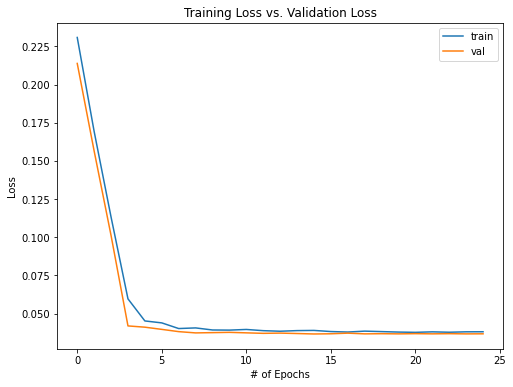

In [238]:
MONITOR = 'val_loss'
PATIENCE = 10
RESTORE_BEST_WEIGHTS = True
ES = tf.keras.callbacks.EarlyStopping(monitor=MONITOR, patience=PATIENCE, 
                                    restore_best_weights=RESTORE_BEST_WEIGHTS)

LOSS = 'mae'
OPTIMIZER = 'adam'
EPOCHS = 500
CALLBACKS = [ES]
VERBOSE = 2

model_params = Model_Params(LOSS, OPTIMIZER, EPOCHS, CALLBACKS, VERBOSE)
model_name = 'LSTM_1'
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.LSTM(100),
    tf.keras.layers.Dense(1)
])

obj.evaluate_and_plot(model_name=model_name, model=model, model_params=model_params)


Epoch 1/500
21/21 - 5s - loss: 0.2328 - val_loss: 0.2160
Epoch 2/500
21/21 - 0s - loss: 0.1716 - val_loss: 0.1539
Epoch 3/500
21/21 - 0s - loss: 0.1089 - val_loss: 0.0908
Epoch 4/500
21/21 - 0s - loss: 0.0563 - val_loss: 0.0461
Epoch 5/500
21/21 - 0s - loss: 0.0534 - val_loss: 0.0384
Epoch 6/500
21/21 - 0s - loss: 0.0448 - val_loss: 0.0385
Epoch 7/500
21/21 - 0s - loss: 0.0438 - val_loss: 0.0368
Epoch 8/500
21/21 - 0s - loss: 0.0423 - val_loss: 0.0372
Epoch 9/500
21/21 - 0s - loss: 0.0408 - val_loss: 0.0370
Epoch 10/500
21/21 - 0s - loss: 0.0444 - val_loss: 0.0377
Epoch 11/500
21/21 - 0s - loss: 0.0428 - val_loss: 0.0362
Epoch 12/500
21/21 - 0s - loss: 0.0411 - val_loss: 0.0378
Epoch 13/500
21/21 - 0s - loss: 0.0438 - val_loss: 0.0365
Epoch 14/500
21/21 - 0s - loss: 0.0429 - val_loss: 0.0382
Epoch 15/500
21/21 - 0s - loss: 0.0438 - val_loss: 0.0375
Epoch 16/500
21/21 - 0s - loss: 0.0415 - val_loss: 0.0371
Epoch 17/500
21/21 - 0s - loss: 0.0430 - val_loss: 0.0367
Epoch 18/500
21/21 - 0s

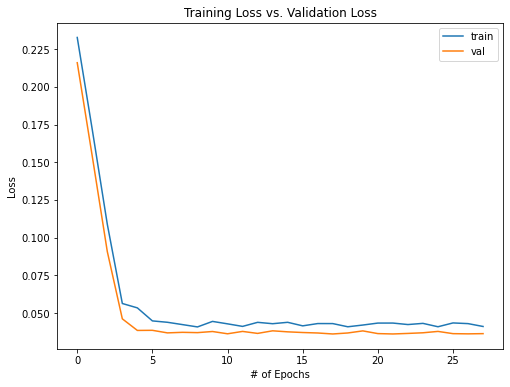

In [239]:
MONITOR = 'val_loss'
PATIENCE = 10
RESTORE_BEST_WEIGHTS = True
ES = tf.keras.callbacks.EarlyStopping(monitor=MONITOR, patience=PATIENCE, 
                                    restore_best_weights=RESTORE_BEST_WEIGHTS)

LOSS = 'mae'
OPTIMIZER = 'adam'
EPOCHS = 500
CALLBACKS = [ES]
VERBOSE = 2

model_params = Model_Params(LOSS, OPTIMIZER, EPOCHS, CALLBACKS, VERBOSE)
model_name = 'LSTM_2'
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(100),
    tf.keras.layers.Dense(1)
])

obj.evaluate_and_plot(model_name=model_name, model=model, model_params=model_params)


Epoch 1/500
21/21 - 5s - loss: 0.2381 - val_loss: 0.2244
Epoch 2/500
21/21 - 0s - loss: 0.1864 - val_loss: 0.1678
Epoch 3/500
21/21 - 0s - loss: 0.1243 - val_loss: 0.1076
Epoch 4/500
21/21 - 0s - loss: 0.0707 - val_loss: 0.0402
Epoch 5/500
21/21 - 0s - loss: 0.0531 - val_loss: 0.0378
Epoch 6/500
21/21 - 0s - loss: 0.0480 - val_loss: 0.0424
Epoch 7/500
21/21 - 0s - loss: 0.0469 - val_loss: 0.0363
Epoch 8/500
21/21 - 0s - loss: 0.0465 - val_loss: 0.0364
Epoch 9/500
21/21 - 0s - loss: 0.0445 - val_loss: 0.0369
Epoch 10/500
21/21 - 0s - loss: 0.0470 - val_loss: 0.0368
Epoch 11/500
21/21 - 0s - loss: 0.0421 - val_loss: 0.0367
Epoch 12/500
21/21 - 0s - loss: 0.0462 - val_loss: 0.0361
Epoch 13/500
21/21 - 0s - loss: 0.0450 - val_loss: 0.0372
Epoch 14/500
21/21 - 0s - loss: 0.0442 - val_loss: 0.0367
Epoch 15/500
21/21 - 0s - loss: 0.0452 - val_loss: 0.0360
Epoch 16/500
21/21 - 0s - loss: 0.0446 - val_loss: 0.0368
Epoch 17/500
21/21 - 0s - loss: 0.0446 - val_loss: 0.0366
Epoch 18/500
21/21 - 0s

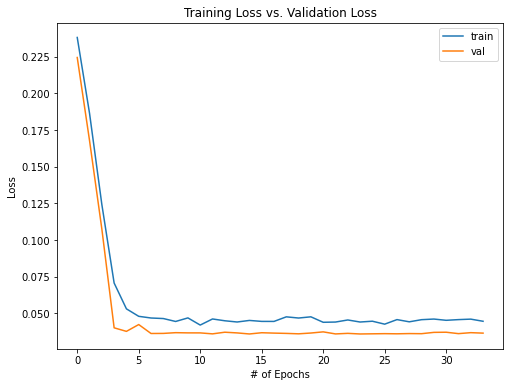

In [240]:
MONITOR = 'val_loss'
PATIENCE = 10
RESTORE_BEST_WEIGHTS = True
ES = tf.keras.callbacks.EarlyStopping(monitor=MONITOR, patience=PATIENCE, 
                                    restore_best_weights=RESTORE_BEST_WEIGHTS)

LOSS = 'mae'
OPTIMIZER = 'adam'
EPOCHS = 500
CALLBACKS = [ES]
VERBOSE = 2

model_params = Model_Params(LOSS, OPTIMIZER, EPOCHS, CALLBACKS, VERBOSE)
model_name = 'LSTM_3'
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(100),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])

obj.evaluate_and_plot(model_name=model_name, model=model, model_params=model_params)

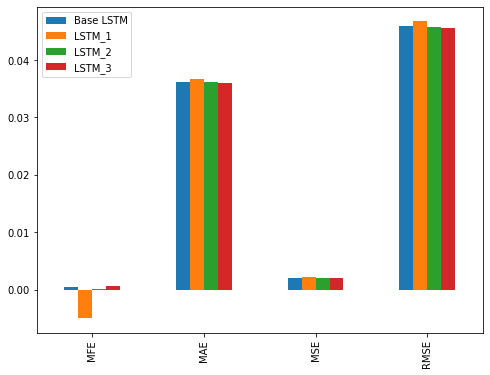

      Base LSTM    LSTM_1    LSTM_2    LSTM_3
MFE    0.000404 -0.004915  0.000164  0.000719
MAE    0.036118  0.036674  0.036093  0.036004
MSE    0.002107  0.002182  0.002095  0.002072
RMSE   0.045902  0.046717  0.045774  0.045516


In [241]:
obj.performance_metrics()